# Starbucks Capstone Challenge

### Overview

For this challenge, Starbucks has provided simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. Not all users receive the same offer.

Starburks interest is to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

#### Data provided:
portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)  
profile.json - demographic data for each customer  
transcript.json - records for transactions, offers received, offers viewed, and offers completed

### Problem Statement

I would like to use "what worked in the past" to send the same "successful" offer to similar profile users.  
<br>
Demographics and spending behaviours will define the profile of a user.  
<br>
The grade of "success" of an offer will be define as following:
1. Offer has been visualised and completed - greatest level of success
1. Offer hasn't been sent to the customer at all - if any other offer "failed" (see points below) the best we can do for the same type of user is to sent an offer that hasn't been sent before. The worst thing it will happen, it will increase the knowledge of success/fail in our database and the model will be more accurate in the next run
1. If a customer has seen the offer but did not complete it, or he/she hasn't either visualise or complete the offer or - worst scenario for Starbucks - has used the offer without visualising it (causing losing of revenue), those will all be considered a "fail" and probably we would not like to suggest those offer to similar user in future
1. If a profile has receive ALL types of offer and they are all a "fail" then probably that type of user just want to be left alone. The best reccomandation is probably Offer 0, meaning do not sent any offer to them  
<br>
I will use Decision Tree to define the "profile". The reason I chose this model is because it will automatically pick up the right relevant range of income/spending behaviour and incorporate them with demographics. 


### Metrics

Data description:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record  

Offer id, after a proper restructure to determine the most successful offer for each user (see Problem Statement), will the label for our Model.  
Age, lenght of membership (calculated from became_member_on), gender, income, and average transaction amount (calculated from value) will be used as metrics in the model



In [1]:
#Importing the necessary libraries and files

import pandas as pd
import numpy as np
import math
import json
import sys
!{sys.executable} -m pip install graphviz
import graphviz
% matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import tree
import pydotplus
from pydotplus import graph_from_dot_data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

#read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
print('Portfolio samples')
portfolio.head(15)

Portfolio samples


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
print('Profile samples')
profile.head()

Profile samples


,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
print('transcript samples')
transcript.head()

transcript samples


,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


### Data Exploration and Cleaning

In [5]:
# The first thing I need to check is the number of offers available and if the id contains any duplicates

print ("There are {} types of offer and there are {} duplicates in portfolio dataset".format(portfolio.shape[0],portfolio.shape[0]-portfolio['id'].nunique()))
print("If the answer above is zero duplicates, the dataset can be used")

There are 10 types of offer and there are 0 duplicates in portfolio dataset
If the answer above is zero duplicates, the dataset can be used


In [6]:
# I need to check if my relevant column are all populated.
# Relevant column for the model are: difficulty, id and offer type

print("Null value in difficulty: {}".format(portfolio['difficulty'].isna().sum()))
print("Null value in id: {}".format(portfolio['id'].isna().sum()))
print("Null value in offer_type: {}".format(portfolio['offer_type'].isna().sum()))

print('If all the values are zero the dataset can be used')

Null value in difficulty: 0
Null value in id: 0
Null value in offer_type: 0
If all the values are zero the dataset can be used


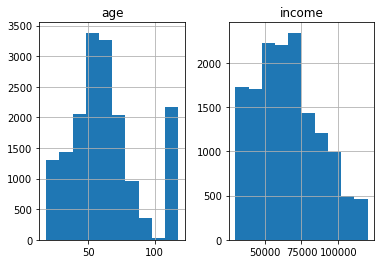

In [7]:
#Every column in the profile is relevant for the model
#It will be interesting to see a distribuition of numeric values

hist = profile[['age','income']].hist()

Nothing particular relevant in terms of income. The most recurrent income is around 75000.  
Age is showing around 2000 ids older than 100 years, which looks like a data error. Needs further exploration

In [8]:
profile.loc[profile['age']>=100, ['age']].groupby(by=["age"]).size()

age
100      12
101       5
118    2175
dtype: int64

We can see there is a suspicious recurrent of 118 years old. That is probably an error

In [9]:
profile[(profile['age']>=100) & (profile['age']<=101)]

,age,became_member_on,gender,id,income
283,100,20150828,F,24c1287eb7a84cfd80472a82e05b1d57,63000.0
1171,100,20170905,F,28bbebb2b76f4057b1115dd80441e37a,118000.0
1556,101,20171004,F,4d2ccfcbbebf4bd9baf4b7e433d0e288,43000.0
1612,100,20180123,F,857fc6e18cf74f7b8ebce26bbfbd3028,109000.0
4100,101,20150526,F,d2fdc2be8ab64e4ba04830d441e53fd5,99000.0
4277,100,20150911,M,b12e8e0f14ae4ad0b576f7c016e7e89b,98000.0
6061,100,20180410,F,9b675a966bd040eeac75f9aa01b14773,70000.0
6902,100,20171231,F,85f4e5ea5c0044619482bfe16ae32c01,71000.0
7129,100,20171126,F,be79870ff776461d97e1aee515269644,47000.0
10939,100,20160629,O,9eb812054d564bdba180dc365f186e23,83000.0


100 and 101 years old is possible and the data looks good in gender, income, and membership data. This data can be used.  
Let's focus on the suspicious 118 years old

In [10]:
#checking null values for 118 years old

print(profile[profile['age']==118].isna().sum())

print ("Gender and income are all NULLs for 118 years old. That confirms those rows cannot be used and needs to be removed from our dataset")

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64
Gender and income are all NULLs for 118 years old. That confirms those rows cannot be used and needs to be removed from our dataset


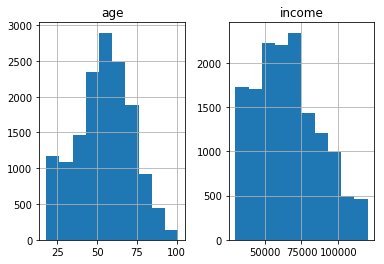

In [11]:
#Removing the 118 years old

profile = profile[profile['age']<118]
hist = profile[['age','income']].hist()

We still need to investigate the Null remaining in profile and make a decision how to handle them.

In [12]:
profile.isna().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

Sorting out the 118 years old has sorted all the null problems.  
We now needs to make sure that id does not contains any duplicates

In [13]:
print ("There are {} ids and there are {} duplicates in profile dataset".format(profile.shape[0],profile.shape[0]-profile['id'].nunique()))
print("If the answer above is zero duplicates, the dataset can be used")

There are 14825 ids and there are 0 duplicates in profile dataset
If the answer above is zero duplicates, the dataset can be used


We now needs to focus on the data quality of the event dataset.  
As usual, let's first check for nulls

In [14]:
print("Null value in event: {}".format(transcript['event'].isna().sum()))
print("Null value in person: {}".format(transcript['person'].isna().sum()))
print("Null value in value: {}".format(transcript['value'].isna().sum()))

print('If all the values are zero there is nothing to do in terms of null handling')

Null value in event: 0
Null value in person: 0
Null value in value: 0
If all the values are zero there is nothing to do in terms of null handling


In [15]:
#Focus on types of event
transcript.groupby(by=["event"]).size()


event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
dtype: int64

### Data preparation

In order to be used in the decision tree, we need to create a dataset with the following columns:  
- age  
- Membership_lenght (in days)
- gender (1 for M, 2 for F, 3 for O)  
- income 
- Avg_transaction_amt 
- One offer_id per person id, choosing "the most successful one" for the user. Adding Offer0 if all the offer type has been presented to the user and they all failed

Offer_id will be the label for the model 

In [16]:
# Preparing Membership_length and gender

import time
import datetime

#Membership_length
#Creating the column became_member_on_date which transform the integer became_member_on into a date
profile['year']=profile['became_member_on']//10000
profile['month']= profile['became_member_on']//100 - profile['year']*100
profile['day']= profile['became_member_on'] - (profile['became_member_on']//100)*100
profile['became_member_on_date'] = pd.to_datetime(profile[['year', 'month', 'day']])

#Creating column Current_date - using a fixed date for development purpose
profile['current_date'] = pd.to_datetime('2021/03/19', format='%Y/%m/%d')

#Finally, calculate membership_lenght
profile['Membership_length'] = (profile['current_date'] - profile['became_member_on_date']).dt.days

#Gender
profile['Gender_int'] = np.where(profile['gender'] == 'M', 1, np.where(profile['gender'] == 'F',2,3))
profile.head()

,age,became_member_on,gender,id,income,year,month,day,became_member_on_date,current_date,Membership_length,Gender_int
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,2017-07-15,2021-03-19,1343,2
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,2017-05-09,2021-03-19,1410,2
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,26,2018-04-26,2021-03-19,1058,1
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,9,2018-02-09,2021-03-19,1134,1
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,11,2017-11-11,2021-03-19,1224,1


For the purpose of our model, we would like to define the most successful offer.  
Most successful means that the customer has used the offer intentionally and it was the most profitable one for Starbucks.  
For the above reason, we will eliminate the informative ones from our analysis

In [17]:
portfolio = portfolio[portfolio["offer_type"]!='informational']
portfolio.head(15)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [18]:
# The transcript dataset contains transaction values, which will be used to calculate Avg_weekly_spent, 
# and the offers viewes/received/completed, which will be used to determine the success grade of an offer
# It makes sense to split into 2 dataset
# Before doing that, we need to extract the amount and the offer id from the column value

transcript['value'] = transcript['value'].astype(str)
transcript['value_clear'] = transcript["value"].str.split(':').str[1]
#Trnascation and offer needs different cleaning
transcript['value_clear'] = np.where(transcript['event'] == 'transaction', transcript["value_clear"].str.split("}").str[0],transcript["value_clear"].str.split("'").str[1])
transcript.head()





,event,person,time,value,value_clear
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0


In [19]:
#Now we are ready to split the transaction dataset between transaction and offer

Transaction = transcript[transcript['event']=='transaction']
Offer = transcript[transcript['event']!='transaction']
Transaction =Transaction.rename(columns={"value_clear": "amount"})
Offer = Offer.rename(columns={"value_clear": "Offer_id"})

#Amount needs to be numeric
Transaction['amount']=Transaction['amount'].astype(float)

#As for the explanation above, we need to remove the informational offer
Offer = Offer[(Offer["Offer_id"]!='3f207df678b143eea3cee63160fa8bed') & (Offer["Offer_id"]!='5a8bc65990b245e5a138643cd4eb9837')]


In [20]:
# For the transaction dataset, we need the average of the amount for each person
Avg_Amt = Transaction.groupby('person', as_index=False)['amount'].mean()

#For the Offer dataset we need more processing
# In Order to understand the "success" of an offer (see Problem statement)
# We need to have one row per person + offer_id and the 3 status (received, viewed and completed) on the same row

#First step: get all possible combination of person + offer_id (including the ones that haven't been offered)
People = transcript[['person']].drop_duplicates()
Offers = portfolio[['id']].drop_duplicates()
People['key'] = 1
Offers['key'] = 1
Person_Offer_id = pd.merge(People, Offers, how="left", on='key')
Person_Offer_id = Person_Offer_id.drop(columns='key')
Person_Offer_id = Person_Offer_id.rename(columns={"id": "Offer_id"})


#Add the received
result = pd.merge(Person_Offer_id, Offer.loc[Offer['event']=='offer received',['person','Offer_id', 'event', 'time']], how="left", on=["person", "Offer_id"])
result = result.rename(columns={"event": "Offer_Received","time":"Time_Received"})
#Add the viewed
result = pd.merge(result, Offer.loc[Offer['event']=='offer viewed',['person','Offer_id', 'event', 'time']], how="left", on=["person", "Offer_id"])
result = result.rename(columns={"event": "Offer_Viewed","time":"Time_Viewed"})
#Add the complete
result = pd.merge(result, Offer.loc[Offer['event']=='offer completed',['person','Offer_id', 'event', 'time']], how="left", on=["person", "Offer_id"])
result = result.rename(columns={"event": "Offer_Completed","time":"Time_Completed"})
#Adding Difficulty, duration, reward. We will use it in case the same grade of success will apply to more than one offer 
Offer_complete_view = pd.merge(result, portfolio[['id', 'difficulty','duration','reward']].rename(columns={"id": "Offer_id"}), how="left", on=["Offer_id"])
Offer_complete_view.head()


,person,Offer_id,Offer_Received,Time_Received,Offer_Viewed,Time_Viewed,Offer_Completed,Time_Completed,difficulty,duration,reward
0,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,offer received,408.0,offer viewed,408.0,offer completed,510.0,10,7,10
1,78afa995795e4d85b5d9ceeca43f5fef,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,NaN,NaN,NaN,10,5,10
2,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,0.0,offer viewed,6.0,offer completed,132.0,5,7,5
3,78afa995795e4d85b5d9ceeca43f5fef,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,NaN,NaN,NaN,20,10,5
4,78afa995795e4d85b5d9ceeca43f5fef,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN,NaN,NaN,NaN,7,7,3


In [21]:
#Now that the complete_offer_view has been created we can start calculate the level of success of each offer

#The first step will consist in eliminate all the fails:
#1. Customer has seen an offer but did not complete it
#2. customer neither visualise or complete the offer
#3. customer complete the offer without visualising it
#3.b customer complete the offer and only visualise it later

#Eliminating fail 1
Offer_complete_view.drop(Offer_complete_view[(pd.notnull(Offer_complete_view["Offer_Viewed"])) & (pd.isnull(Offer_complete_view["Offer_Completed"]))].index, inplace=True)

#Eliminating fail 2
Offer_complete_view.drop(Offer_complete_view[(pd.isnull(Offer_complete_view["Offer_Viewed"])) & (pd.isnull(Offer_complete_view["Offer_Completed"])) & (pd.notnull(Offer_complete_view["Offer_Received"]))].index, inplace=True)

#Eliminating fail 3
Offer_complete_view.drop(Offer_complete_view[(pd.isnull(Offer_complete_view["Offer_Viewed"])) & (pd.notnull(Offer_complete_view["Offer_Completed"]))].index, inplace=True)

#Eliminating fail 3.b
Offer_complete_view.drop(Offer_complete_view[(pd.notnull(Offer_complete_view["Offer_Viewed"])) & (pd.notnull(Offer_complete_view["Offer_Completed"])) & (Offer_complete_view['Time_Viewed'] > Offer_complete_view['Time_Completed'])].index, inplace=True)


Offer_complete_view.head()

,person,Offer_id,Offer_Received,Time_Received,Offer_Viewed,Time_Viewed,Offer_Completed,Time_Completed,difficulty,duration,reward
0,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,offer received,408.0,offer viewed,408.0,offer completed,510.0,10,7,10
1,78afa995795e4d85b5d9ceeca43f5fef,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,NaN,NaN,NaN,10,5,10
2,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,0.0,offer viewed,6.0,offer completed,132.0,5,7,5
3,78afa995795e4d85b5d9ceeca43f5fef,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,NaN,NaN,NaN,20,10,5
4,78afa995795e4d85b5d9ceeca43f5fef,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN,NaN,NaN,NaN,7,7,3


We now need to establish a way to define what was the most successful offer for each person.  
<br>
In order to do that, we will create a rating model as following:
1. Score for completeness: If the offer is completed the score is 1, else is 0
2. Score for difficulty: difficulty/100
3. Score for speed: 1/(Time_completed - Time_viewed)*0.001
 - If Time_completed = Time_viewed then score is maximum: 0.001  
 - If Time_completed is null then score is minimum: 0
5. Score for reward: reward/10000000
4. Score for duration: duration/1000000000

The final score will be: Score for completeness + Score for difficulty + Score for speed + Score for duration + Score for reward
<br>
Reason for the weights:
 - A non-completed offer should not be more successfule than a complete one, regardless the difficulty or the speed
 - Among completed offers, a less profitable offer should not be more successful than a more profitable one, regardless the speed
 - In case of parity across completeness, difficulty and speed, the one with the highest reward will be selected
 - In case of parity across completeness, difficulty, speed and reward the one with the longest duration will be selected; to give as much time as possible to the user to consider the offer


In [22]:
Offer_complete_view['Score_for_completeness'] = np.where(pd.notnull(Offer_complete_view["Offer_Completed"]), 1,0)
Offer_complete_view['Score_for_difficulty'] = Offer_complete_view['difficulty']/100
Offer_complete_view['Score_for_speed'] = np.where(pd.isnull(Offer_complete_view["Offer_Completed"]),0,np.where(Offer_complete_view["Time_Completed"]==Offer_complete_view["Time_Viewed"],0.001,(1/(Offer_complete_view["Time_Completed"]-Offer_complete_view["Time_Viewed"])*0.001)))
Offer_complete_view['Score_for_reward'] = Offer_complete_view['reward']/10000000
Offer_complete_view['Score_for_duration'] = Offer_complete_view['duration']/1000000000
Offer_complete_view['Total_Score'] = Offer_complete_view['Score_for_completeness'] + Offer_complete_view['Score_for_difficulty'] + Offer_complete_view['Score_for_speed'] + Offer_complete_view['Score_for_duration'] + Offer_complete_view['Score_for_reward']
Offer_complete_view.describe()

,Time_Received,Time_Viewed,Time_Completed,difficulty,duration,reward,Score_for_completeness,Score_for_difficulty,Score_for_speed,Score_for_reward,Score_for_duration,Total_Score
count,45075.000000,45075.000000,45075.000000,130438.000000,130438.000000,130438.000000,130438.000000,130438.000000,130438.000000,1.304380e+05,1.304380e+05,130438.000000
mean,329.927454,314.086522,426.918602,9.331276,7.233958,5.136111,0.345566,0.093313,0.000040,5.136111e-07,7.233958e-09,0.438919
std,195.982848,196.694194,186.348747,4.135759,1.791473,3.002389,0.475554,0.041358,0.000168,3.002389e-07,1.791473e-09,0.473468
min,0.000000,0.000000,0.000000,5.000000,5.000000,2.000000,0.000000,0.050000,0.000000,2.000000e-07,5.000000e-09,0.050001
25%,168.000000,168.000000,312.000000,7.000000,5.000000,2.000000,0.000000,0.070000,0.000000,2.000000e-07,5.000000e-09,0.100000
50%,336.000000,348.000000,462.000000,10.000000,7.000000,5.000000,0.000000,0.100000,0.000000,5.000000e-07,7.000000e-09,0.100001
75%,504.000000,504.000000,582.000000,10.000000,7.000000,5.000000,1.000000,0.100000,0.000008,5.000000e-07,7.000000e-09,1.070006
max,576.000000,708.000000,714.000000,20.000000,10.000000,10.000000,1.000000,0.200000,0.001000,1.000000e-06,1.000000e-08,1.201001


In [23]:
#We now need to identify, for each person, the offer with the highest score:

Max_score_per_person = Offer_complete_view.groupby('person', as_index=False)['Total_Score'].max()
Max_score_per_person = Max_score_per_person.rename(columns={"Total_Score": "Max_Score"})

#And join back to Offer_complete_view
Offer_complete_view = pd.merge(Offer_complete_view, Max_score_per_person, how="left", on="person")
#And keep only the highest score offer
Offer_complete_view = Offer_complete_view[Offer_complete_view['Total_Score']==Offer_complete_view['Max_Score']]

#Let's check if we have one best offer per person 
Offer_complete_view.groupby('person').Offer_id.nunique().reset_index().sort_values(by='Offer_id', ascending=False)


,person,Offer_id
0,0009655768c64bdeb2e877511632db8f,1
11338,a93cb9e04f5a4ffa8beeb6e6a51333ca,1
11324,a9012cc8c7d94d2aae450ea4c314d394,1
11325,a9035280036b4e21bfe017153319c1b3,1
11326,a906be760afd4edb815302cab24a60d6,1
11327,a906c9eb943e4fbab2655d893a372705,1
11328,a90cad5df2e44266abbea4736c061ec7,1
11329,a90ef297656f4150af47cd391adf276a,1
11330,a910bf664b7746fa8ee405e943958ca6,1
11331,a91155f8df7740389524af9b94b66a9a,1


We now have one best offer id per person.  
We only need to eliminate duplicates and the score columns that we don't need anymore

In [24]:
Recc_offer_per_person = Offer_complete_view[['person','Offer_id']].drop_duplicates()
Recc_offer_per_person.shape[0]

17000

The last scenario we need to consider is Offer0.  
A customer has received ALL the offer and they all failed. Probably the best reccomandation for them is Offer0, meaning do not sent any offer at all, until a new type of offer wil be insert in the database.  
We do not have any customer like this at all at this stage but we may in the future, so let's prepare the code

In [25]:
# If a customer is an "Offer 0" one, its id has been delete completed from Offer_complete_view during the elimination of fails stage
# We need to reintroduce him/her
Recc_offer_per_person = pd.merge(People[['person']], Recc_offer_per_person, how="left", on=["person"])
Recc_offer_per_person['Offer_id'] = np.where(pd.isnull(Recc_offer_per_person["Offer_id"]), 'Offer0',Recc_offer_per_person["Offer_id"])

Before Training the model, we now need to include demographics and average transiction amount

In [26]:
profile= profile.rename(columns={"id": "person"})
Model_data = pd.merge(profile[['age','person','income','Membership_length','Gender_int']], Avg_Amt, how="left", on="person")
Model_data = pd.merge(Model_data, Recc_offer_per_person, how="left", on="person")
Model_data.head()

,age,person,income,Membership_length,Gender_int,amount,Offer_id
0,55,0610b486422d4921ae7d2bf64640c50b,112000.0,1343,2,25.670000,0b1e1539f2cc45b7b9fa7c272da2e1d7
1,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1410,2,22.752857,ae264e3637204a6fb9bb56bc8210ddfd
2,68,e2127556f4f64592b11af22de27a7932,70000.0,1058,1,19.243333,fafdcd668e3743c1bb461111dcafc2a4
3,65,389bc3fa690240e798340f5a15918d5c,53000.0,1134,1,12.143333,fafdcd668e3743c1bb461111dcafc2a4
4,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1224,1,3.905000,fafdcd668e3743c1bb461111dcafc2a4


In [27]:
# Since we have joined to different dataframe together, let's check if we have any person in the profile dataset that 
# did not exist in the transcript dataset

print("People without a best offer: {}".format(Model_data['Offer_id'].isna().sum()))
print("People with average amount unknown: {}".format(Model_data['amount'].isna().sum()))

People without a best offer: 0
People with average amount unknown: 333


We have 333 people that do not use the app for paying so no transaction appear.  
This can be very useful information for the model. In order to use it, we will change null with zero

In [28]:
Model_data['amount'] = Model_data['amount'].fillna(0)

### Training and Testing the Model

In [29]:
# First step will be to create our X (metrics) and Y (labels) dataset
X = Model_data[['age','Membership_length','amount','Gender_int','income']]
Y = Model_data[['Offer_id']]

In [30]:
# Creating a function which will train and test the model and prints the evaluation scores

def build_test_ev(x,y,test_per):
    """
    Building, Testing and Evaluating a decision tree model
    
    Parameters:
    x (dataframe): dataframe with features
    y (dataframe): dataframes with labels
    test_per (float): percentage of the dataframe to be used for testing
    
    Returns:
    clf: decision tree model
    X_train: the training dataframe
    l: list of offer_id
    
    """
    # Splitting the dataset on Train and test. 30% will be used for testing
    X_train, X_test, Y_train, Y_test = train_test_split(x,y,random_state = 23, test_size = test_per)

    # Training the model
    clf = tree.DecisionTreeClassifier(min_samples_split=40)
    clf = clf.fit(X_train, Y_train)

    # Making prediction with the trained model
    Y_pred = clf.predict(X_test)
    
    # Calculate confusion matrix
    List_of_offer = y[['Offer_id']].drop_duplicates().values
    #we need to flatten the list
    l = [item for sublist in List_of_offer for item in sublist]

    print('Confusion Matrix')
    print(confusion_matrix(Y_test, Y_pred, labels=l))
    
    print("Accuracy score is {}".format(accuracy_score(Y_test, Y_pred)))
    print("F1 score is {}".format(f1_score(Y_test, Y_pred,average='weighted', labels=l)))
    print("Recall score is {}".format(recall_score(Y_test, Y_pred, average='weighted', labels=l)))
    print("Precision score is {}".format(precision_score(Y_test, Y_pred, labels=l, average='weighted')))
    
    return clf, X_train, l

In [31]:
# running the model
DTM, x_train, l_offer = build_test_ev(X,Y,0.3)

Confusion Matrix
[[482 169 176 101  56  11  30   1]
 [285 150 174  94  37   8  30   0]
 [258 143 229 110  48  14  40   1]
 [195 122 125  91  25   2  33   0]
 [166  75 110  52  38   5  22   0]
 [ 93  40  49  30  19   7  11   0]
 [ 89  71 100  49  26   4  18   1]
 [ 44  22  34  18   8   1   6   0]]
Accuracy score is 0.22819244604316546
F1 score is 0.20513104199013846
Recall score is 0.22819244604316546
Precision score is 0.19860749751311227


The scores are not great, let us have a look at the feature importance

In [32]:
df_feature_importance = pd.DataFrame(DTM.feature_importances_, index=x_train.columns.values, columns=['feature importance']).sort_values('feature importance', ascending=False)
df_feature_importance

,feature importance
amount,0.366480
Membership_length,0.294754
age,0.191089
income,0.132326
Gender_int,0.015350


We don't have a big number of feature so ideally we should increase with more information rather than reducing the column. However, let us try to elimininate the least two significant feature

In [33]:
# Eliminating Gender_int, income
X = Model_data[['age','Membership_length','amount']]
Y = Model_data[['Offer_id']]

In [34]:
DTM, x_train, l_offer = build_test_ev(X,Y,0.3)

Confusion Matrix
[[490 148 198  95  56   8  30   1]
 [290 128 188  91  46   8  27   0]
 [261 117 244 108  59   8  43   3]
 [200  89 144  95  33   3  28   1]
 [181  53 136  46  37   2  12   1]
 [ 80  37  72  31  10   7  12   0]
 [109  51  95  57  31   1  14   0]
 [ 46  17  39  18   7   0   6   0]]
Accuracy score is 0.22819244604316546
F1 score is 0.20279524322948392
Recall score is 0.22819244604316546
Precision score is 0.19913645845931682


The scores did not change much, confirming that the chances for the model to perform better will be with more features and data and not the opposite.  
<br>
The code below will plot the decision tree just create. The tree is very big for the image but it is still interesting to navigate with cursor

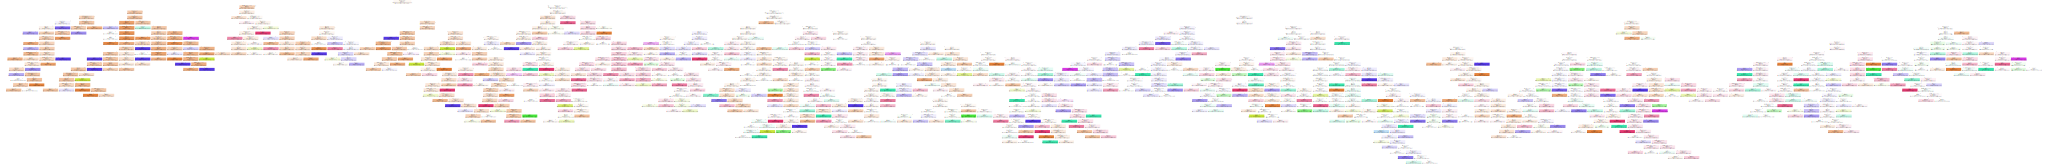

In [35]:
dot_data = tree.export_graphviz(DTM, out_file=None, 
                                feature_names=x_train.columns.values,  
                                class_names=l_offer,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

### Conclusion
We have experimented the use of a combination of decision tree and success scoring to identify the best offer based on demographics like age, membership lenght, income, gender and average transaction amount.  
Gender and income did not proved to be the most relevant feature of the model.  
The model did not shown high accuracy, F1, recall and precision score however further experiments with higher number of data and collecting higher number of features could make the model more accurate. The benefit of this type of model would be enable reccomandations with no cold start problem and without the necessity to use Funk_SVD.  
This model was also meant to be "iterative" and to learn more every run. Let us remember that if we don't have completed offer for a particular user, we made the best guessing in success based on highest profit and longest duration. Once that user has received the model reccomandation, he/she will determined success/fail, increasing the model's knowledge 

Don't forget to check the blog about this project:  
https://medium.com/@eva-marchetti/learning-from-customers-response-to-offers-ed7553e0b931